In [633]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import random
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

### Обзор, анализ и визуализация данных

In [634]:
#Считываем данные
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')

In [635]:
#Давайте на них посмотрим
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


meantemp - Средняя температура


humidity - Влажность

wind_speed - Скорость ветра

meanpressure - Среднее давление

In [636]:
#Посмотрим на статистические данные наших данных
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [637]:
#Преобразуем даты в подходящий формат
df['date'] = pd.to_datetime(df["date"])
df_test['date'] = pd.to_datetime(df_test["date"])


In [638]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

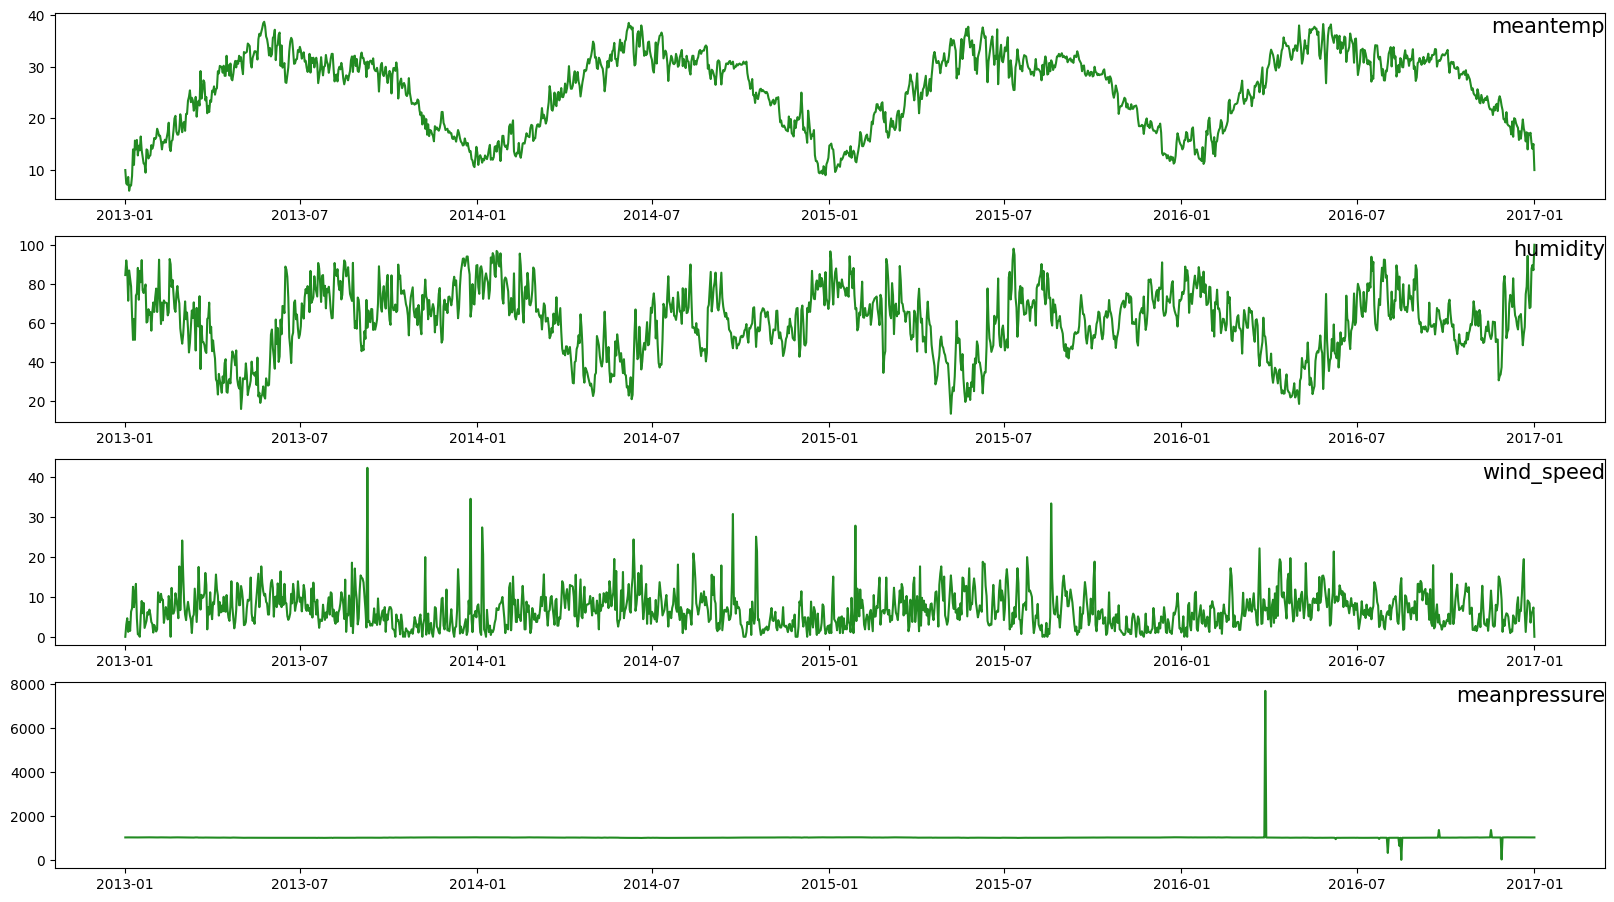

In [639]:
#Функция рисования фичей датасета
def simple_draw(df_list):
    colors = ["forestgreen", 'blue', 'red', 'brown', 'purple']
    target_columns = list(df_list[0].columns)
    target_columns.remove('date')
    date = 'date'
    plt.figure(figsize=(20,14))
    i = 1
    for column in target_columns:
        plt.subplot(len(df_list[0].columns), 1, i)
        for j in range(len(df_list)):
            plt.plot(df_list[j][date], df_list[j][column], c = colors[j])
        plt.title(column, y=0.85, loc='right', fontsize = 15)
        i += 1
    plt.show()

simple_draw([df])

### Удаление выбросов

In [640]:
column = 'meanpressure'
for i, v in enumerate(df[column]):
    if i > 1 and i < len(df)-1:
        if v > 1100 or v < 980:
            df[column][i] = (df[column][i-1]+df[column][i+1])/2

df_test[column][0] = df_test[column][1]

column = 'wind_speed'
for i, v in enumerate(df[column]):
    if i > 1 and i < len(df)-1:
        if v > 30:
            df[column][i] = (df[column][i-1]+df[column][i+1])/2

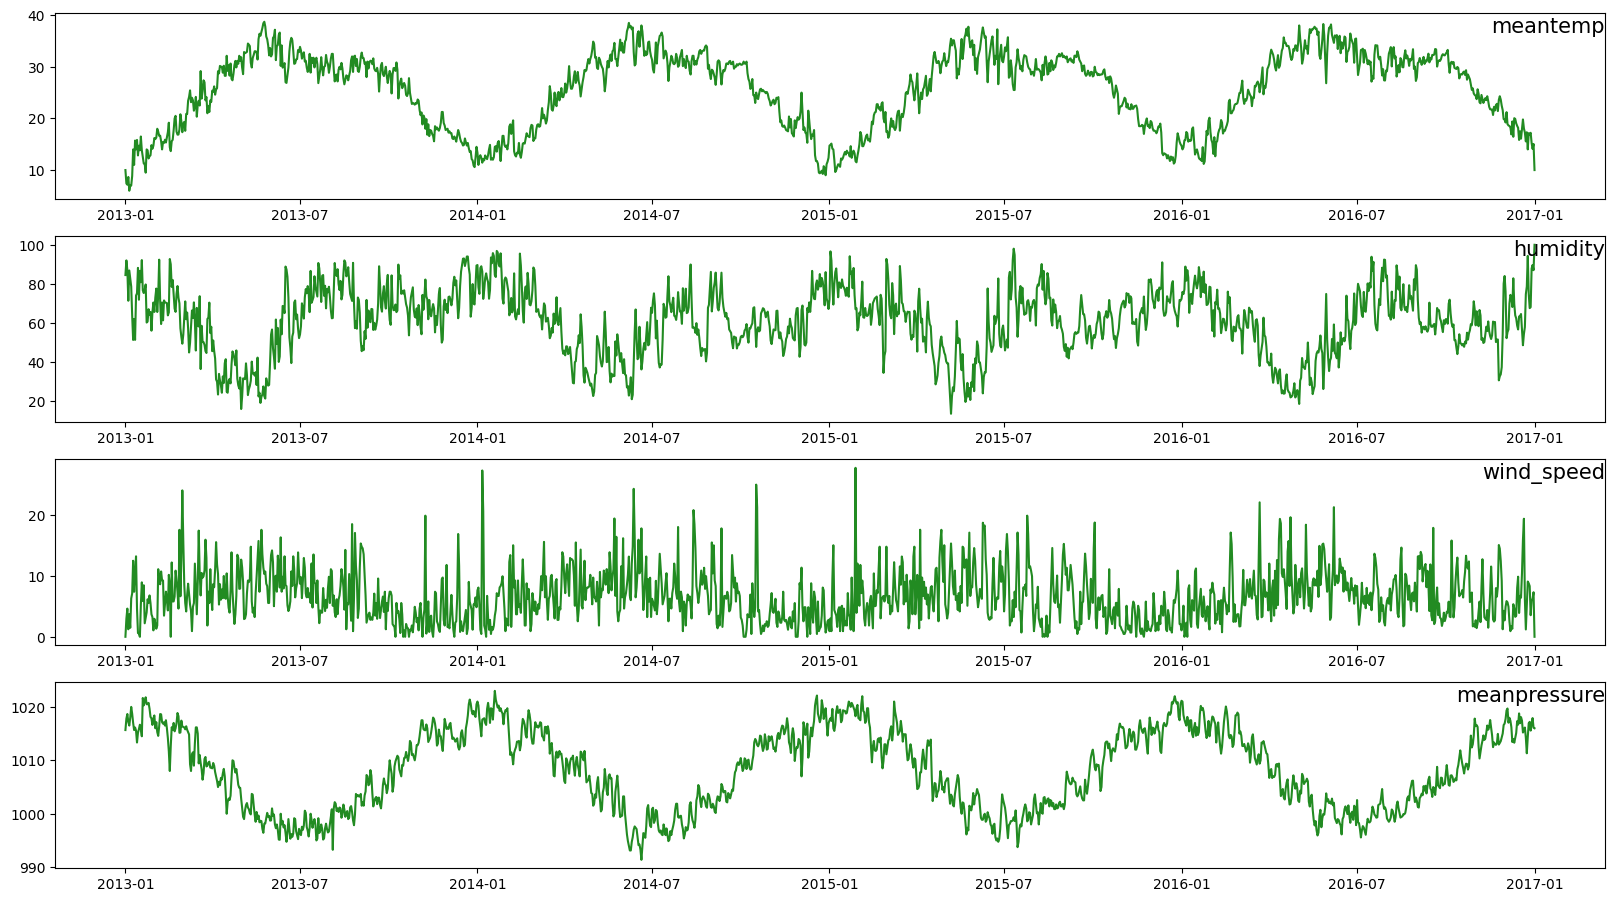

In [641]:
simple_draw([df])

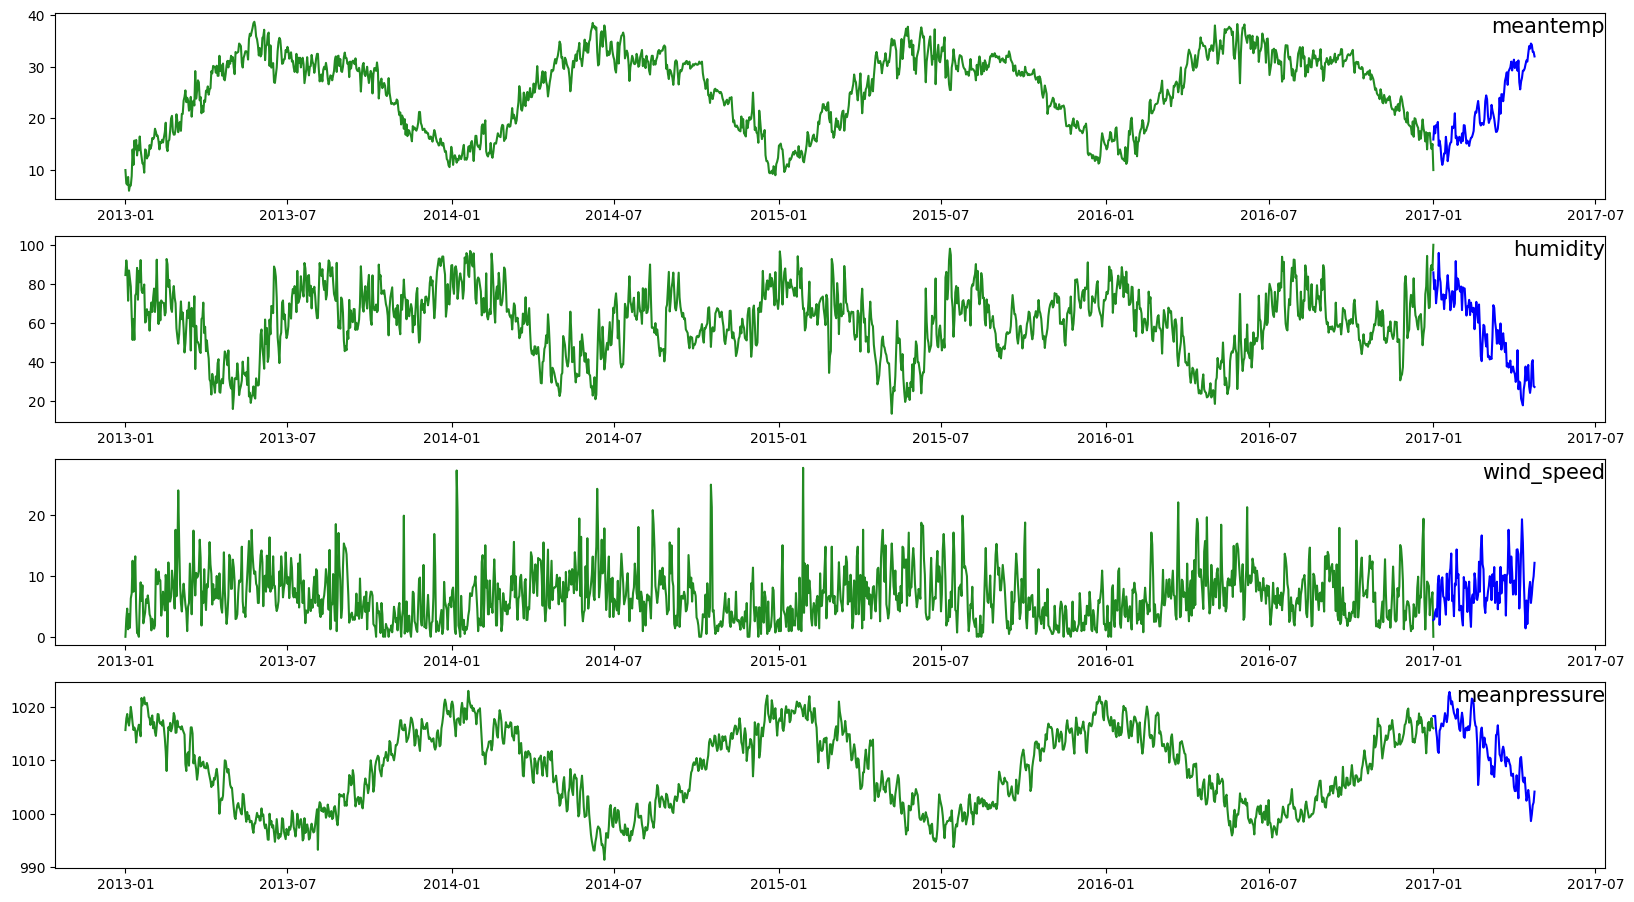

In [642]:
simple_draw([df,df_test])

### Проверка на пустые значения

In [643]:
#Проверим на пустые названия
missing_values = df.isnull().sum()
missing_values = pd.DataFrame(missing_values[missing_values>0])
missing_values

,0


### Проверка на равные интервалы(1 час)

In [644]:
date_diff = df['date'].diff()

# Проверка, есть ли значения, отличающиеся от 10 минут
result = (date_diff == pd.Timedelta(hours=1)).all()
result

False

### Анализ временного ряда

In [645]:
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
alpha = 0.05
#Тест Дики фуллера
def test_diki(name, ts):
    alpha = 0.05
    print(f'Тест Дики-Фуллера для {name}:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")
#Собсвтенно проведем тест
for column in df.columns:
    name = column
    ts = df[column]
    test_diki(name, ts)

Тест Дики-Фуллера для date:
Test Statistic                   10.845598
p-value                           1.000000
#Lags Used                       14.000000
Number of Observations Used    1447.000000
Critical Value (1%)              -3.434877
Critical Value (5%)              -2.863539
Critical Value (10%)             -2.567835
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.
Тест Дики-Фуллера для meantemp:
Test Statistic                   -2.021069
p-value                           0.277412
#Lags Used                       10.000000
Number of Observations Used    1451.000000
Critical Value (1%)              -3.434865
Critical Value (5%)              -2.863534
Critical Value (10%)             -2.567832
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.
Тест Дики-Фуллера для humidity:
Test Statistic                   -3.675577
p-value                           0.004470
#Lags Used                       15.000000
Number of Observations Used    1446.000000
Critical Value

Ряды не стационарны. Для нейросетей это не очень важно, а вот для классических моделей придеться чуть подиффиринциирвоать позже

In [646]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johan_test_temp = df.drop('date', axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([2.34942350e-01, 6.31507227e-02, 9.12678146e-03, 6.74688304e-07])

In [647]:
# import warnings
# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
#     dfn = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in tqdm(dfn.columns):
#         for r in dfn.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     dfn.columns = [var + '_x' for var in variables]
#     dfn.index = [var + '_y' for var in variables]
#     return dfn
# warnings.filterwarnings("ignore")
# j_test = grangers_causation_matrix(df, variables = df.columns)
# warnings.filterwarnings("default")
# j_test

### Немножко фича-инжиниринга

Введем столбец коэфецента влажности

In [648]:
#Введем дополнительный столбец характеризуюзий коэфицент влажности
df['humidity per meanpressure'] = df['humidity'] / df['meanpressure']
df_test['humidity per meanpressure'] = df_test['humidity'] / df_test['meanpressure']

### LSTM

In [649]:
#количество данных в датасете
count = len(df) 
ndf = df.copy()

In [650]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
ss1 = StandardScaler()
ss2 = StandardScaler()
ss = StandardScaler()
inv_ss = None
#Создает датасет с указанным lookback-window
def create_datasets(lookback):
    features = ['humidity', 'wind_speed', 'meanpressure', 'humidity per meanpressure']
    target = 'meantemp'

    X = ndf[features].values
    Y = ndf[target].values

    X_test = df_test[features].values
    Y_test = df_test[target].values
  
    global inv_ss
    inv_ss = ss.fit(Y.reshape(-1, 1))
    X = ss1.fit_transform(X)
    X_test = ss1.transform(X_test)
    Y = ss2.fit_transform(Y.reshape(-1, 1)).reshape(1, -1)[0]
    Y_test = ss2.transform(Y_test.reshape(-1, 1)).reshape(1, -1)[0]
    
    
    n_features = X.shape[1]

    X_organized, Y_organized = [], []
    for i in range(0, X.shape[0]-lookback, 1):
        X_organized.append(X[i:i+lookback])
        Y_organized.append(Y[i+lookback])

    X_test_organized, Y_test_organized = [], []
    for i in range(0, X_test.shape[0]-lookback, 1):
        X_test_organized.append(X_test[i:i+lookback])
        Y_test_organized.append(Y_test[i+lookback])

    X_organized, Y_organized = np.array(X_organized), np.array(Y_organized)
    X_organized, Y_organized = torch.tensor(X_organized, dtype=torch.float32), torch.tensor(Y_organized, dtype=torch.float32)

    X_test_organized, Y_test_organized = np.array(X_test_organized), np.array(Y_test_organized)
    X_test_organized, Y_test_organized = torch.tensor(X_test_organized, dtype=torch.float32), torch.tensor(Y_test_organized, dtype=torch.float32)

    X_train, Y_train = X_organized, Y_organized
    X_test, Y_test = X_test_organized, Y_test_organized

    train_dataset = TensorDataset(X_train, Y_train)
    test_dataset  = TensorDataset(X_test,  Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle= False)
    test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle= False)

    return n_features, X_train, Y_train, X_test, Y_test, train_dataset, train_loader, train_dataset, test_loader

In [660]:
from torch.nn import functional as F
import torch.nn as nn

#Сама нейросеть
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_dim, n_layers, lookback):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout1d(0.2)
        self.linear = nn.Linear(hidden_dim*2, 32)
        self.linear2 = nn.Linear(32,1)
        self.linear3 = nn.Linear(16, 1)
        self.norm = nn.BatchNorm1d(lookback)
        self.sigmoid = nn.Sigmoid()
        self.lrelu = nn.LeakyReLU()

    def forward(self, X_batch):
        hidden, carry = torch.randn(self.n_layers*2, len(X_batch), self.hidden_dim), torch.randn(self.n_layers*2, len(X_batch), self.hidden_dim)
        output, (hidden, carry) = self.lstm(X_batch, (hidden, carry))
        output = self.dropout(output)
        output = self.linear(output)
        output = self.sigmoid(output)
        return self.linear2(output[:,-1])

In [661]:
from IPython import display
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

#Обучение переданной модели по переданным параметрам
def learn(model, optimizer, num_epochs, criterion, train_dataloader, df_for_pred, df_real, df_for_pred_tr, df_real_tr, lookback, tittle = "", scheduler = None):
    loss_history = []
    epoch_loss_history = []
    train_mae = []
    train_loss =[]
    test_loss = []

    strings = []
    for i in range(num_epochs):
        #Учимся
        model.train()
        for x_batch, y_batch in train_dataloader:
            predictions = model.forward(x_batch)
            
            loss = criterion(predictions, y_batch)

            loss.backward()

            optimizer.step()
            optimizer.zero_grad() 

            if scheduler != None:
                scheduler.step()

            loss_history.append(loss.item())
        model.eval()
        #Рисуем графики и проводим промежуточную валдиацию модели 
        with torch.no_grad():
            epoch_loss_history.append(loss.item())
            fig, axs = plt.subplots(nrows= 3, ncols= 1,  figsize=(15,10))
            display.clear_output(wait=True)

            test_preds = model(df_for_pred)
            test_preds = inv_ss.inverse_transform(test_preds.detach().numpy())
            data_df_final = df_real.copy()
            data_df_final["meantemp preds"] = test_preds.squeeze().tolist()

            train_preds = model(df_for_pred_tr)
            train_preds = inv_ss.inverse_transform(train_preds.detach().numpy())
            data_df_final_train = df_real_tr.copy()
            data_df_final_train["meantemp preds"] = train_preds.squeeze().tolist()
                
            train_loss.append(mean_squared_error(data_df_final_train['meantemp'][lookback:], data_df_final_train['meantemp preds'][lookback:]))
            test_loss.append(mean_squared_error(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:]))

            axs[0].set_title(f"Training loss {i+1}/{num_epochs} {tittle}")
            axs[0].set_xlabel("#iteration")
            axs[0].set_ylabel("loss")
            axs[0].plot(loss_history, 'b')

            temp_train_mae = r2_score(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:])
            train_mae.append(temp_train_mae)
            axs[1].set_title(f"R2 {i+1}/{num_epochs} {tittle}")
            axs[1].plot(train_mae, 'g', label = 'train')

            axs[2].set_title(f"Train\\test loss {i+1}/{num_epochs} {tittle}")
            axs[2].set_xlabel("#iteration")
            axs[2].set_ylabel("loss")
            tr, = axs[2].plot(test_loss, 'b')
            te, =axs[2].plot(train_loss, 'r')
            axs[2].legend([tr, te], ['train', 'test'])


            plt.show()
            strings.append(f'{i+1}/{num_epochs} current loss: {train_mae[i]}')
            for s in strings:
                print(s) 

In [662]:
# ## ------------------------------------- Переборчик
# from torch.optim import Adam
# r2s = {}
# for hid in [16, 32, 64, 128, 512]:
#     for lookback in range(20, 40, 2):
#         n_features, X_train, Y_train, X_test, Y_test, train_dataset, train_loader, train_dataset, test_loader = create_datasets(lookback)

#         epochs = 30
#         learning_rate = 1e-3
#         loss_fn = nn.MSELoss()

#         lstm_regressor = LSTMRegressor(n_features, hid, 2, lookback)
#         optimizer = Adam(lstm_regressor.parameters(), lr=learning_rate)

#         learn(lstm_regressor, optimizer, epochs, loss_fn, train_loader,  X_test, df_test[lookback:], lookback, f"{lookback}   {hid}")

#         test_preds = lstm_regressor(X_test)
#         test_preds = inv_ss.inverse_transform(test_preds.detach().numpy())
#         data_df_final = df_test[lookback:].copy()
#         data_df_final["meantemp preds"] = test_preds.squeeze().tolist()
#         r2s[f"lookback : {lookback}, hid : {hid}"] = r2_score(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:])
# sorted(r2s.items(), key = lambda x : x[1], reverse= True)

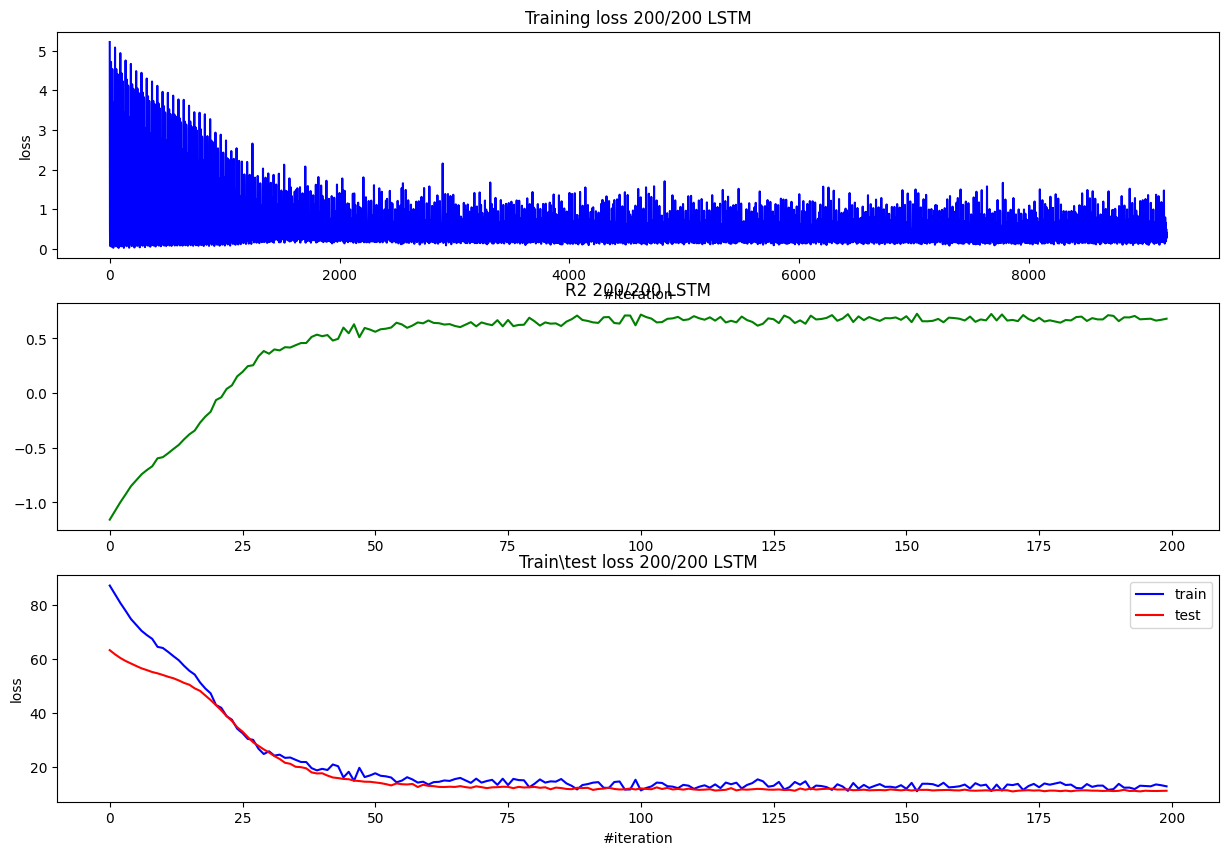

1/200 current loss: -1.157595448176599
2/200 current loss: -1.0781060955935682
3/200 current loss: -0.9978201460701845
4/200 current loss: -0.925527023318421
5/200 current loss: -0.850860662597096
6/200 current loss: -0.7959558558493729
7/200 current loss: -0.7425528417718199
8/200 current loss: -0.7034420206702889
9/200 current loss: -0.6691746226507236
10/200 current loss: -0.5963111789228943
11/200 current loss: -0.5857908979025466
12/200 current loss: -0.549889260820623
13/200 current loss: -0.5107178906230936
14/200 current loss: -0.47354552703622144
15/200 current loss: -0.4222105346317997
16/200 current loss: -0.3767703557987394
17/200 current loss: -0.34250841771874874
18/200 current loss: -0.2705360342680403
19/200 current loss: -0.2146089571493781
20/200 current loss: -0.17032528441388073
21/200 current loss: -0.06375739787214796
22/200 current loss: -0.03803715899795712
23/200 current loss: 0.038153949162842093
24/200 current loss: 0.07104345153155633
25/200 current loss: 0.

In [672]:
from torch.optim import Adam
#Запустим обучение
lookback = 1

n_features, X_train, Y_train, X_test, Y_test, train_dataset, train_loader, train_dataset, test_loader = create_datasets(lookback)

epochs = 200
learning_rate = 1e-4
loss_fn = nn.MSELoss()

lstm_regressor = LSTMRegressor(n_features, 64, 2, lookback)
#optimizer = Adam(lstm_regressor.parameters(), lr=learning_rate, weight_decay=8e-6)
#optimizer = torch.optim.Adam(lstm_regressor.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = torch.optim.AdamW(lstm_regressor.parameters(), lr=learning_rate)

learn(lstm_regressor, optimizer, epochs, loss_fn, train_loader,  X_test, df_test[lookback:], X_train, ndf[lookback:], lookback, 'LSTM')

In [664]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
def smape( data , pred ):
 return 1/ len (data) * np.sum (2 * np.abs (pred-data) / (np.abs (data) + np.abs (pred)))
#Функция валидации модели по тестовой выборке
def validate(model, df_for_pred, df_real):
    test_preds = model(df_for_pred)
    test_preds = inv_ss.inverse_transform(test_preds.detach().numpy())
    data_df_final = df_real.copy()
    data_df_final["meantemp preds"] = test_preds.squeeze().tolist()
    data_df_final.plot(y=["meantemp", "meantemp preds"],figsize=(18,7))
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    print("RMSE:", np.sqrt(mean_squared_error(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:])))
    print("MAPE:", mean_absolute_percentage_error(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:]))
    print("MAE:", mean_absolute_error(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:]))
    print("R2: ", r2_score(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:]))
    print("SMAPE: ", smape(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:]))

RMSE: 3.6399166903544846
MAPE: 0.1555540013376515
MAE: 2.9188138530983276
R2:  0.6721573901562194
SMAPE:  0.14075988619596644


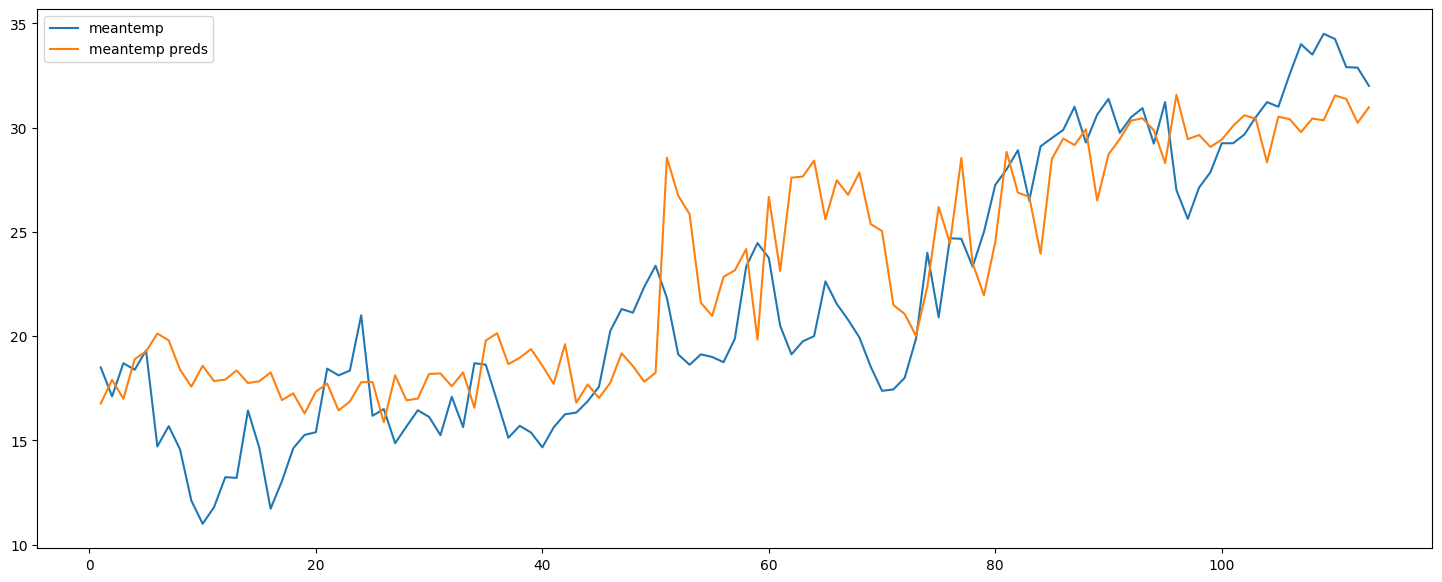

In [674]:
#Проваледируем нашу лстм
validate(lstm_regressor, X_test, df_test[lookback:])

Получилось слабовато, как в прочем-то и все мои нейросети. Я бы погрешил на сложность предсказания погоди и свои кривые ручки, но значиительно выше 0.6 r2 у меня не получилось и на одной из нейросетей 

### GRU

In [675]:
from torch.nn import functional as F
import torch.nn as nn
#Модель ГРУ
class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_dim, n_layers, lookback):
        super(GRURegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout1d(0.2)
        self.linear = nn.Linear(hidden_dim*2, 32)
        self.linear2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X_batch):
        hidden = torch.randn(self.n_layers*2, len(X_batch), self.hidden_dim)
        output, (hidden) = self.gru(X_batch, (hidden.detach()))
        output = self.dropout(output)
        output = self.linear(output)
        output = self.sigmoid(output)
        return self.linear2(output[:,-1])

In [676]:
# ## ------------------------------------- Переборчик
# from torch.optim import Adam
# r2s = {}
# for lookback in range(2, 34, 2):
#     n_features, X_train, Y_train, X_test, Y_test, train_dataset, train_loader, train_dataset, test_loader = create_datasets(lookback)

#     epochs = 15
#     learning_rate = 1e-3
#     loss_fn = nn.MSELoss()

#     gru_regressor = GRURegressor(n_features, 128, 1, lookback)
#     optimizer = Adam(gru_regressor.parameters(), lr=learning_rate)

#     learn(gru_regressor, optimizer, epochs, loss_fn, train_loader,  X_test, df_test[lookback:], lookback, f"{lookback}")

#     test_preds = gru_regressor(X_test)
#     test_preds = inv_ss.inverse_transform(test_preds.detach().numpy())
#     data_df_final = df_test[lookback:].copy()
#     data_df_final["meantemp preds"] = test_preds.squeeze().tolist()
# r2s[f"lookback : {lookback}"] = r2_score(data_df_final['meantemp'][lookback:], data_df_final['meantemp preds'][lookback:])

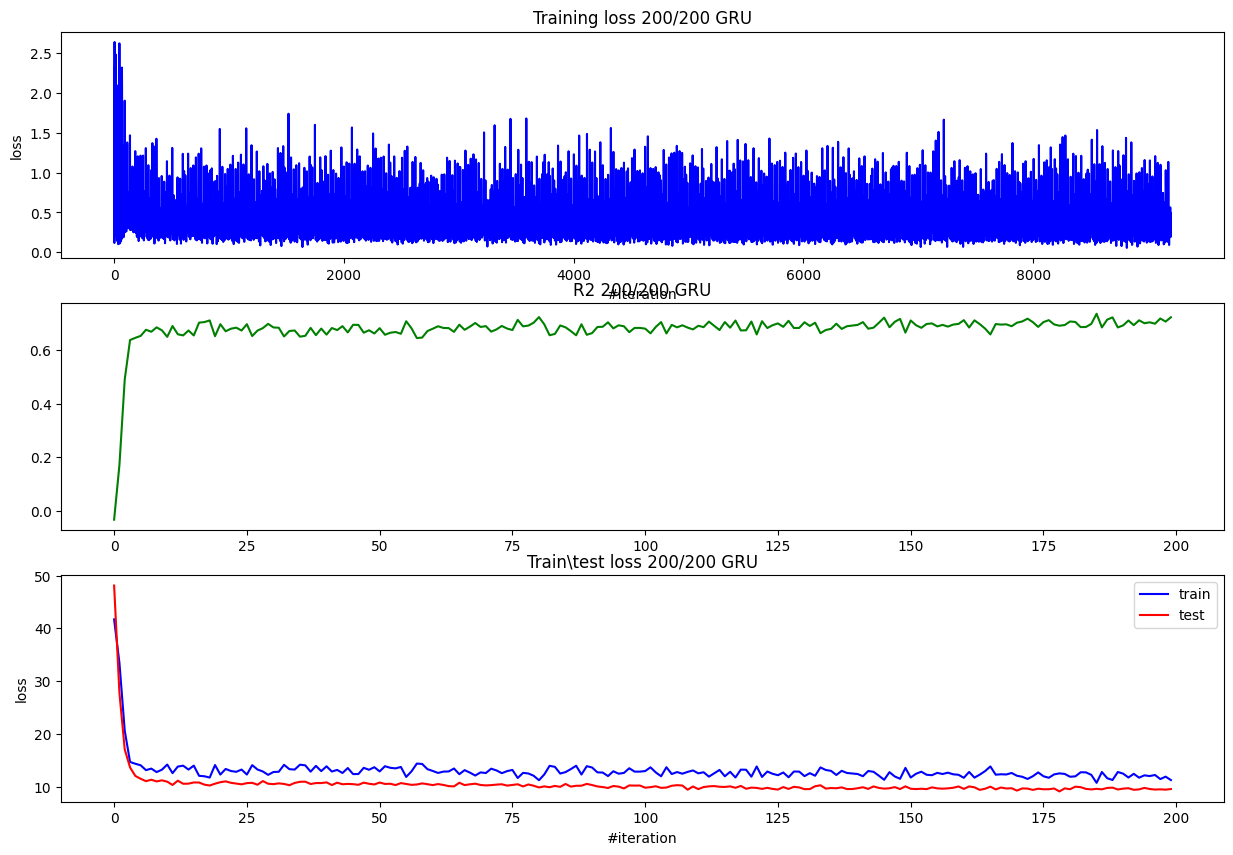

1/200 current loss: -0.03192902326452618
2/200 current loss: 0.17159586888538159
3/200 current loss: 0.4901802389173494
4/200 current loss: 0.636715753437698
5/200 current loss: 0.6450741184023706
6/200 current loss: 0.6522635135775046
7/200 current loss: 0.6750151547615111
8/200 current loss: 0.6677378887690724
9/200 current loss: 0.6840299049680874
10/200 current loss: 0.6730056919381164
11/200 current loss: 0.6487650105551606
12/200 current loss: 0.689027128249229
13/200 current loss: 0.658205290251827
14/200 current loss: 0.6540642421749595
15/200 current loss: 0.6723861934548939
16/200 current loss: 0.6538983299118539
17/200 current loss: 0.7015988282905212
18/200 current loss: 0.7036901519441461
19/200 current loss: 0.709848265053208
20/200 current loss: 0.6510624135092316
21/200 current loss: 0.6957653850829528
22/200 current loss: 0.6694125333398231
23/200 current loss: 0.6790708474237848
24/200 current loss: 0.6827976080817216
25/200 current loss: 0.6723271485301869
26/200 cur

In [678]:
from torch.optim import Adam
#Учим GRU
lookback = 1

n_features, X_train, Y_train, X_test, Y_test, train_dataset, train_loader, train_dataset, test_loader = create_datasets(lookback)

epochs = 200
learning_rate = 1e-3
loss_fn = nn.MSELoss()

gru_regressor = GRURegressor(n_features, 64, 2, lookback)
optimizer = Adam(gru_regressor.parameters(), lr=learning_rate, weight_decay=1e-5)

learn(gru_regressor, optimizer, epochs, loss_fn, train_loader,  X_test, df_test[lookback:], X_train, ndf[lookback:], lookback, 'GRU')

RMSE: 4.04663508962676
MAPE: 0.1562787913379068
MAE: 3.005758796385783
R2:  0.5705570752548212
SMAPE:  0.13718893886153438


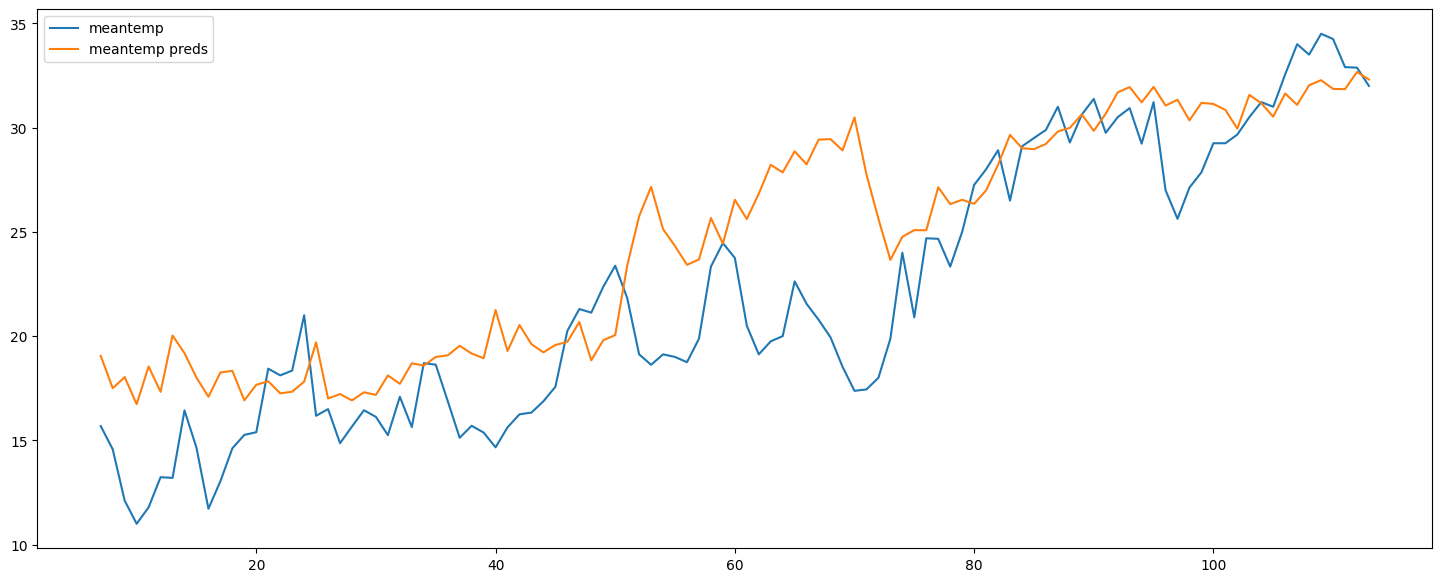

In [ ]:
#Валидируем GRU
validate(gru_regressor, X_test, df_test[lookback:])

По сути получили то же что и у лстм. Буду честен, я на удивление убил на лстм пару дней, даже не знаю почему было настолько трудно. Но по итогу с интернетом я нашел что-то что дало мне 0.6(причем чуть ли не случайно, что особенно иронично зная что перед этим 2 дня я занимался переборами и search-и) и на подбор параметров и архитектур сетей для GRU и RNN времени себе почти не оставил.

### RNN

In [ ]:
from torch.nn import functional as F
import torch.nn as nn
#RNN Модель
class RNNRegressor(nn.Module):
    def __init__(self, n_features, hidden_dim, n_layers, lookback):
        super(RNNRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, nonlinearity='relu', bidirectional=True)
        self.dropout = nn.Dropout1d(0.2)
        self.linear = nn.Linear(hidden_dim*2, 1)

    def forward(self, X_batch):
        hidden = torch.randn(self.n_layers*2, len(X_batch), self.hidden_dim)
        output, (hidden) = self.rnn(X_batch, (hidden.detach()))
        output = self.dropout(output)
        return self.linear(output[:,-1])

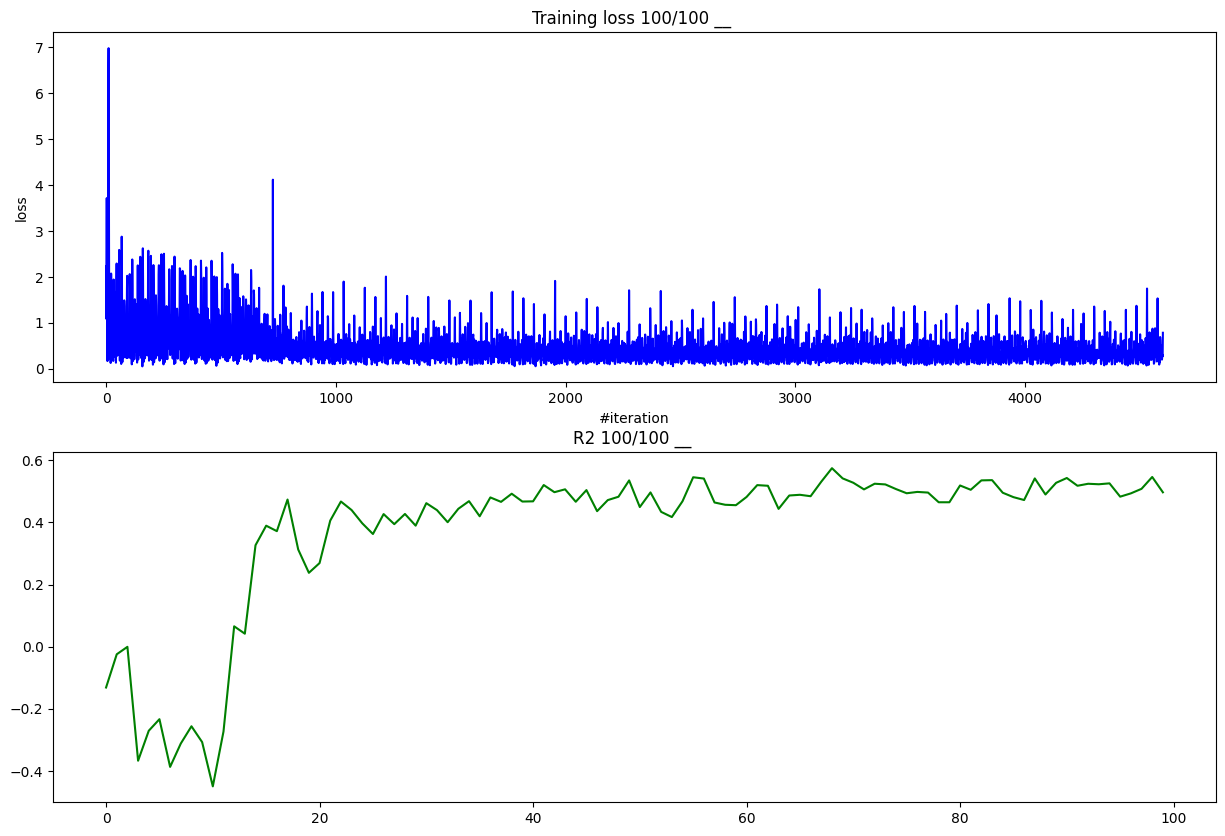

1/100 current loss: -0.13150714323511625
2/100 current loss: -0.024610175194021755
3/100 current loss: -0.0005828031877748163
4/100 current loss: -0.3670994185867309
5/100 current loss: -0.2706497587858696
6/100 current loss: -0.23344041753867395
7/100 current loss: -0.38692925649305776
8/100 current loss: -0.3118160271145489
9/100 current loss: -0.2562518885947729
10/100 current loss: -0.30719365313719393
11/100 current loss: -0.44963102548859846
12/100 current loss: -0.27323305189982916
13/100 current loss: 0.0654335158630317
14/100 current loss: 0.041682288904015596
15/100 current loss: 0.3263906600027008
16/100 current loss: 0.38923634078697567
17/100 current loss: 0.3716540617252422
18/100 current loss: 0.4733929486828635
19/100 current loss: 0.31260425935845626
20/100 current loss: 0.23763557774256305
21/100 current loss: 0.2689420925657616
22/100 current loss: 0.40558048913350553
23/100 current loss: 0.46704743873695287
24/100 current loss: 0.4395915046720634
25/100 current loss

In [ ]:
from torch.optim import Adam
#Учим RNN
lookback = 7

n_features, X_train, Y_train, X_test, Y_test, train_dataset, train_loader, train_dataset, test_loader = create_datasets(lookback)

epochs = 100
learning_rate = 1e-3
loss_fn = nn.MSELoss()

rnn_regressor = RNNRegressor(n_features, 512, 2, lookback)
optimizer = Adam(rnn_regressor.parameters(), lr=learning_rate)

learn(rnn_regressor, optimizer, epochs, loss_fn, train_loader,  X_test, df_test[lookback:], lookback)

RMSE: 4.367937649131279
MAPE: 0.1730764410165259
MAE: 3.3346993854720295
R2:  0.4996542370888337
SMAPE:  0.15161532749265283


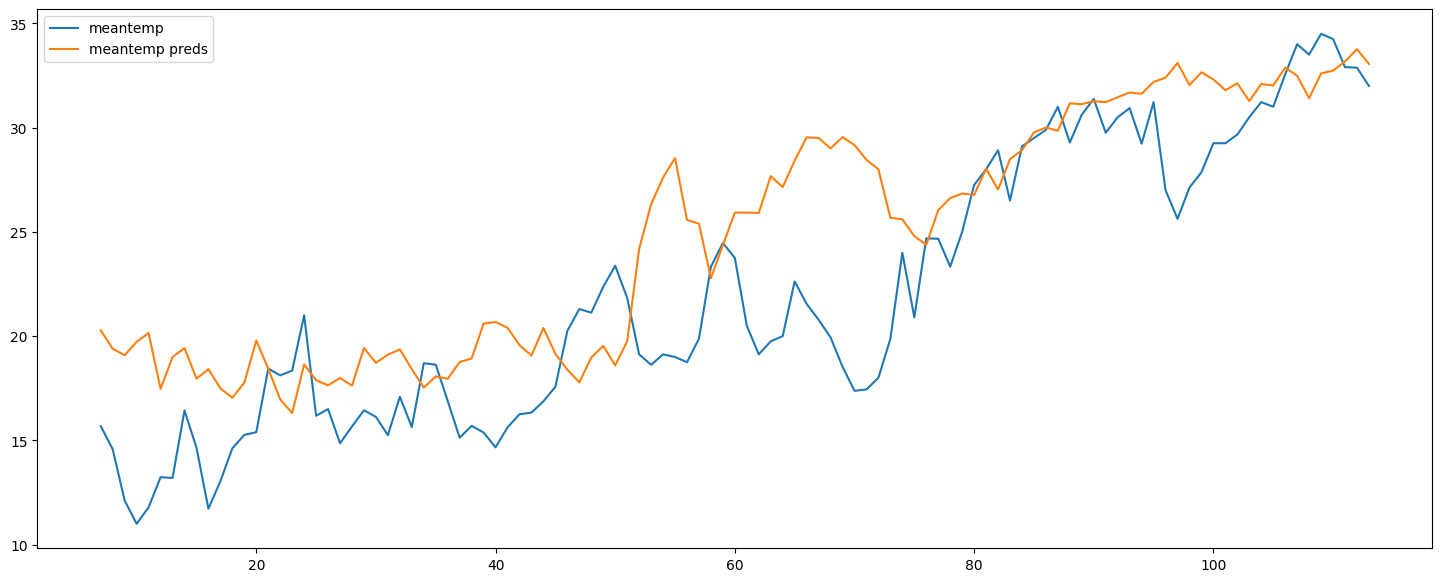

In [ ]:
#валидируем rnn
validate(rnn_regressor, X_test, df_test[lookback:])

Получилось даже хуже чем предыдущие две нейронки

### Классические модели

Удалим тренд во имя стационарности

In [ ]:
#Продифириницируем наши ряды
df_differenced = df.diff().dropna().drop(['date'], axis=1)

In [ ]:
df_differenced

,meantemp,humidity,wind_speed,meanpressure,humidity per meanpressure
1,-2.600000,7.500000,2.980000,2.133333,0.007194
2,-0.233333,-5.000000,1.653333,0.866667,-0.004985
3,1.500000,-15.666667,-3.400000,-1.500000,-0.015276
4,-2.666667,15.500000,2.466667,-0.666667,0.015294
5,1.000000,-4.033333,-2.220000,1.500000,-0.004088
...,...,...,...,...,...
1457,0.367391,0.493478,-4.787174,-1.634783,0.000593
1458,-1.979296,19.813665,2.452174,1.339545,0.019396
1459,-1.142857,1.809524,0.266667,1.000000,0.001693
1460,0.957393,-2.666667,1.058333,-1.804762,-0.002468


In [ ]:
#Проверим помогло ли дифферинциирование
for column in df_differenced.columns:
    name = column
    ts = df_differenced[column]
    test_diki(name, ts)

Тест Дики-Фуллера для meantemp:
Test Statistic                -1.637872e+01
p-value                        2.764863e-29
#Lags Used                     9.000000e+00
Number of Observations Used    1.451000e+03
Critical Value (1%)           -3.434865e+00
Critical Value (5%)           -2.863534e+00
Critical Value (10%)          -2.567832e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера для humidity:
Test Statistic                -1.268353e+01
p-value                        1.172923e-23
#Lags Used                     1.400000e+01
Number of Observations Used    1.446000e+03
Critical Value (1%)           -3.434880e+00
Critical Value (5%)           -2.863541e+00
Critical Value (10%)          -2.567835e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера для wind_speed:
Test Statistic                -1.395051e+01
p-value                        4.711355e-26
#Lags Used                     2.300000e+01
Number of Observations Used    1.437000e

Test Statistic                -1.661671e+01
p-value                        1.712087e-29
#Lags Used                     9.000000e+00
Number of Observations Used    1.451000e+03
Critical Value (1%)           -3.434865e+00
Critical Value (5%)           -2.863534e+00
Critical Value (10%)          -2.567832e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера для humidity per meanpressure:
Test Statistic                -1.269029e+01
p-value                        1.136016e-23
#Lags Used                     1.400000e+01
Number of Observations Used    1.446000e+03
Critical Value (1%)           -3.434880e+00
Critical Value (5%)           -2.863541e+00
Critical Value (10%)          -2.567835e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### VAR

In [ ]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
#Берем тренировачные и тестовые выборки
v_train = df_differenced[:int(0.8*(len(df)))]
v_test = df_differenced[int(0.8*(len(df))):]

In [ ]:
#Преберем параметр p
max_p = 128
model = VAR(v_train)

best_p = model.select_order(maxlags=max_p).selected_orders['aic']

print("Optimal p:", best_p)

c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal p: 11


In [ ]:
model = VAR(v_train)

c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
#Обучимся на лучшем полученном параметре
model_fitted = model.fit(11)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jan, 2024
Time:                     12:50:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -10.0748
Nobs:                     1158.00    HQIC:                  -10.8358
Log likelihood:          -1394.71    FPE:                1.24153e-05
AIC:                     -11.2970    Det(Omega_mle):     9.80407e-06
--------------------------------------------------------------------
Results for equation meantemp
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.016409         0.046581            0.352           0.725
L1.meantemp                          -0.205591         0.042966           -4.785          

In [ ]:
#Создание датасета с окном
def create_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)])
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)])
    return X_test, Y_test

In [ ]:
#собственно создаем датасеты
X_test, Y_test = create_dataset(np.array(v_test.values), 11)
X_train, Y_train = create_dataset(np.array(v_train.values), 11)

In [ ]:
#Предсказываем
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [ ]:
from math import  sqrt
#Рисуем графики и валидируем
def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:,:, n]
        Y_pred = pred[:,:, n]
        Y_train = train[:,:, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        print(f"Метрики {name}")
        print("MSE:", mean_squared_error(Y_true, Y_pred))
        print("RMSE:", sqrt(mean_squared_error(Y_true, Y_pred)))
        print("MAE:", mean_absolute_error(Y_true, Y_pred))
        print("SMAPE:", smape(Y_true, Y_pred))
        print("R2:", r2_score(Y_true, Y_pred),"\n")

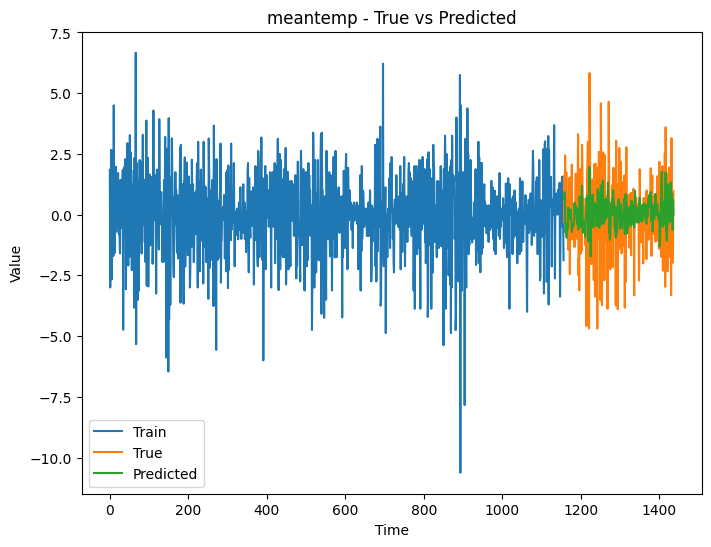

Метрики meantemp
MSE: 2.4608984206304036
RMSE: 1.5687250940271222
MAE: 1.192864651293411
SMAPE: 1.4295098440037068
R2: 0.09179841129052602 



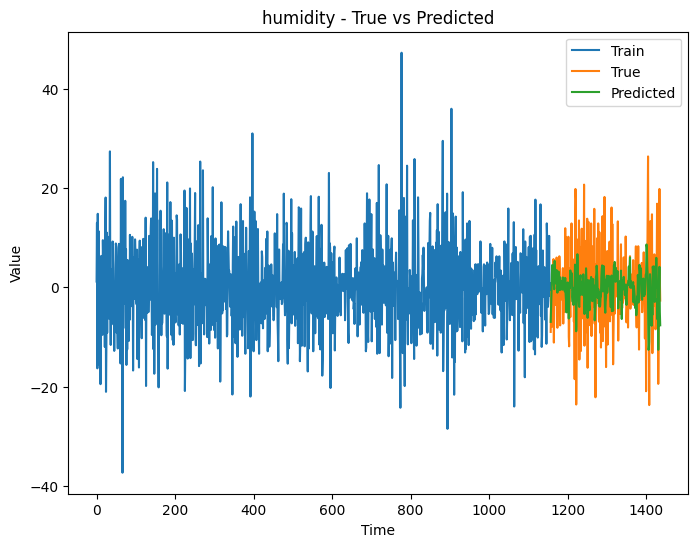

Метрики humidity
MSE: 55.292136477700105
RMSE: 7.435868239667786
MAE: 5.548653082847657
SMAPE: 1.3951238974918245
R2: 0.07471619622516246 



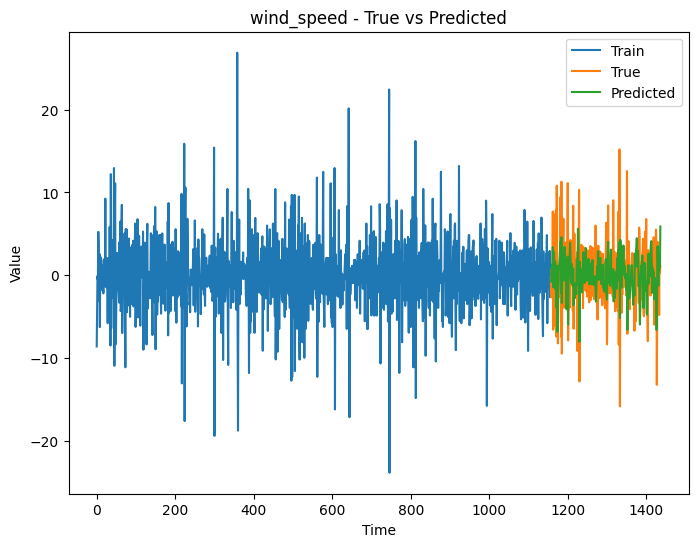

Метрики wind_speed
MSE: 13.040497934019841
RMSE: 3.6111629614322087
MAE: 2.7013882775526326
SMAPE: 1.2141725952716689
R2: 0.20758668541711023 



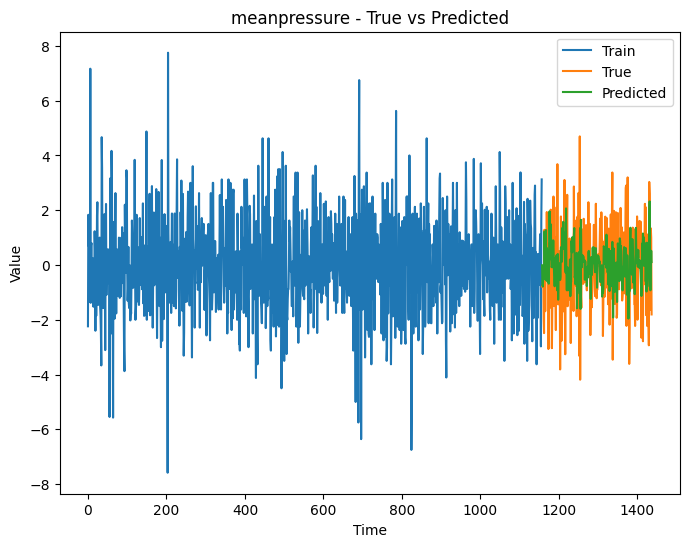

Метрики meanpressure
MSE: 2.2378211009049838
RMSE: 1.495934858509883
MAE: 1.162229822506252
SMAPE: 1.3923371821481283
R2: -0.03234648775269933 



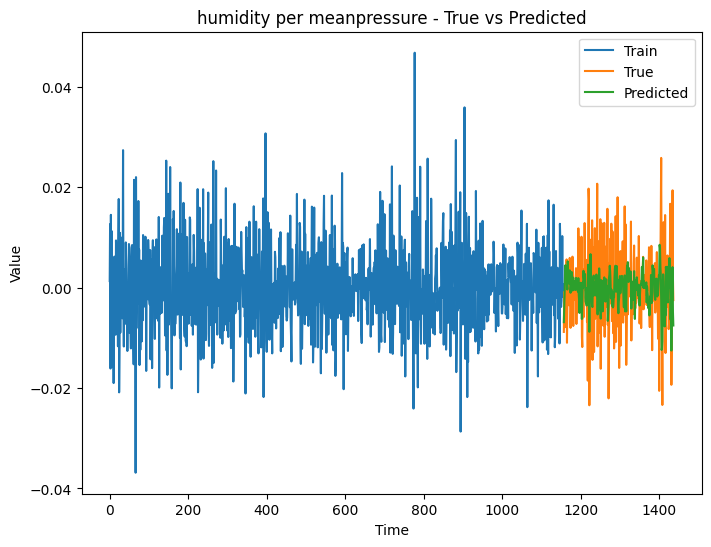

Метрики humidity per meanpressure
MSE: 5.4318072999447894e-05
RMSE: 0.007370079578908758
MAE: 0.005503152898156702
SMAPE: 1.395297290214564
R2: 0.07509040393070421 



In [ ]:
plot_and_metrics(df_differenced.columns, np.array(Y_test), np.array(Y_pred), np.array(Y_train))

Получилось достаточно плохо даже с учетом удаления давления(которое вносит очень сильные неприятные коррективы в предсказания векторной регрессии)

### Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [ ]:
#Готовим датасет(без тагрета)
train_data = df.drop(['meantemp', 'date'], axis = 1)

In [ ]:
#Преобразуем в массивчик
temp_df = np.array(train_data)

In [ ]:
#Готовим таргеты
tar_train = np.array(df['meantemp'][1:int(len(temp_df)*0.8)+1])
tar_test = np.array(df['meantemp'][int(len(temp_df)*0.8)+1:])

In [ ]:
#Готовим фичи
train = temp_df[1:int(len(temp_df)*0.8)+1]
test = temp_df[int(len(temp_df)*0.8)+1:]

In [ ]:
#Переберем параметр максимальной глубины
r2s = {}
for max_d in range(100):
    regr = RandomForestRegressor(max_depth=max_d+1, random_state=42, criterion = 'absolute_error', verbose=10)
    regr.fit(train, tar_train)
    pred = regr.predict(test)
    r2s[max_d+1] = r2_score(tar_test, pred)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.3s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.6s


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.5s


building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.7s


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.6s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.9s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.7s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.1s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.3s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.9s


building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.3s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.3s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.0s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.4s


building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.5s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.1s


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.5s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.5s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.1s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.6s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.4s


building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.2s


building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.8s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.5s


building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.3s


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.8s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.5s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.6s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.3s


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.6s


building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.9s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.5s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.4s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.7s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.0s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.1s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.5s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.6s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.6s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.3s


building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.6s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.3s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.6s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.6s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.3s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.3s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.6s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s


building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.6s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.8s


building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.5s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.8s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.2s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


building tree 50 of 100
building tree 51 of 100


KeyboardInterrupt: 

In [ ]:
#Посмотрим на лучший параметр
sorted(r2s.items(), key=lambda x: x[1], reverse=True)

[(5, 0.7427117483937228),
 (6, 0.7419779531650181),
 (7, 0.7326921722258986),
 (4, 0.7310528803033858),
 (8, 0.7285390135393263),
 (9, 0.7241796099876389),
 (10, 0.7202759977748809),
 (11, 0.7183131038161125),
 (12, 0.7160612213791788),
 (13, 0.713256482783402),
 (14, 0.7118375090900424),
 (22, 0.7116373126014184),
 (24, 0.7112275456920026),
 (18, 0.7109710557259945),
 (23, 0.7109304396740099),
 (26, 0.710299337506695),
 (19, 0.710090102641991),
 (25, 0.7099356200860392),
 (27, 0.7099241814961625),
 (28, 0.7098762043513123),
 (29, 0.7098762043513123),
 (30, 0.7098762043513123),
 (31, 0.7098762043513123),
 (32, 0.7098762043513123),
 (33, 0.7098762043513123),
 (34, 0.7098762043513123),
 (35, 0.7098762043513123),
 (36, 0.7098762043513123),
 (37, 0.7098762043513123),
 (38, 0.7098762043513123),
 (39, 0.7098762043513123),
 (40, 0.7098762043513123),
 (41, 0.7098762043513123),
 (42, 0.7098762043513123),
 (43, 0.7098762043513123),
 (44, 0.7098762043513123),
 (45, 0.7098762043513123),
 (46, 0.70

In [ ]:
#Учимся с лучшим параметром
regr = RandomForestRegressor(max_depth=5, random_state=42, criterion = 'absolute_error', verbose=10)
regr.fit(train, tar_train)
pred = regr.predict(test)
r2s[max_d+1] = r2_score(tar_test, pred)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.3s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.9s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.2s


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s


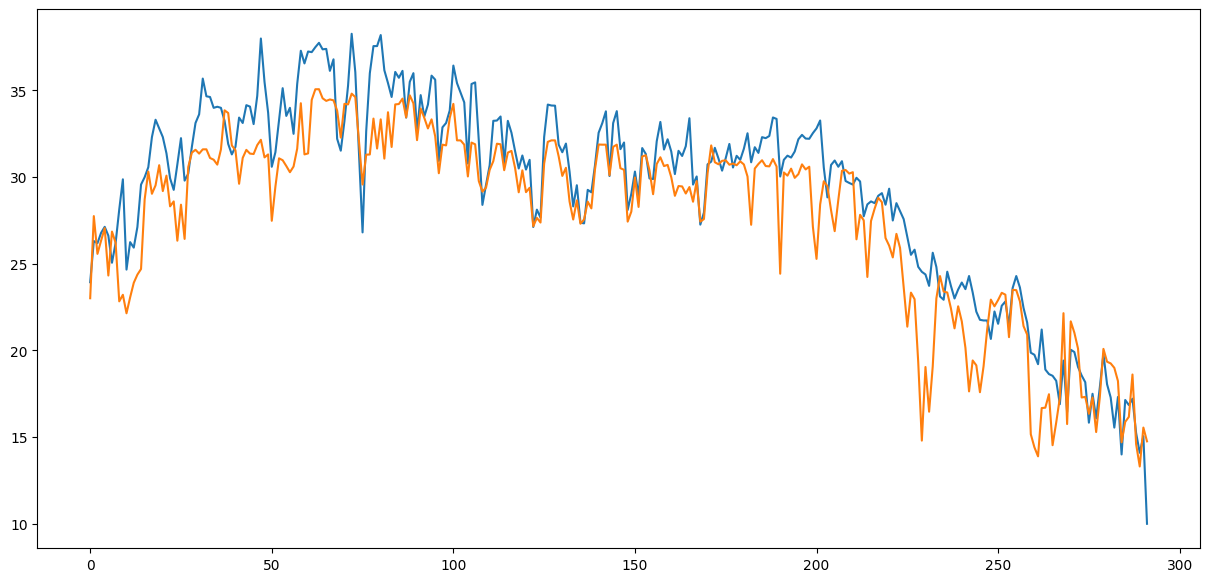

In [ ]:
#Рисуем
plt.figure(figsize = (15,7))
plt.plot(tar_test)
plt.plot(pred)

In [ ]:
#Валидируем
print("RMSE:", np.sqrt(mean_squared_error(tar_test, pred)))
print("MAPE:", mean_absolute_percentage_error(tar_test, pred))
print("MAE:", mean_absolute_error(tar_test, pred))
print("R2: ", r2_score(tar_test, pred))
print("SMAPE: ", smape(tar_test, pred))

RMSE: 2.5472105235207145
MAPE: 0.06956279524331344
MAE: 1.9670329846434165
R2:  0.7974407625363454
SMAPE:  0.07317367314881261


На удивление моя лучшая модель, почти без перебора параметров. Даже как-то обидно